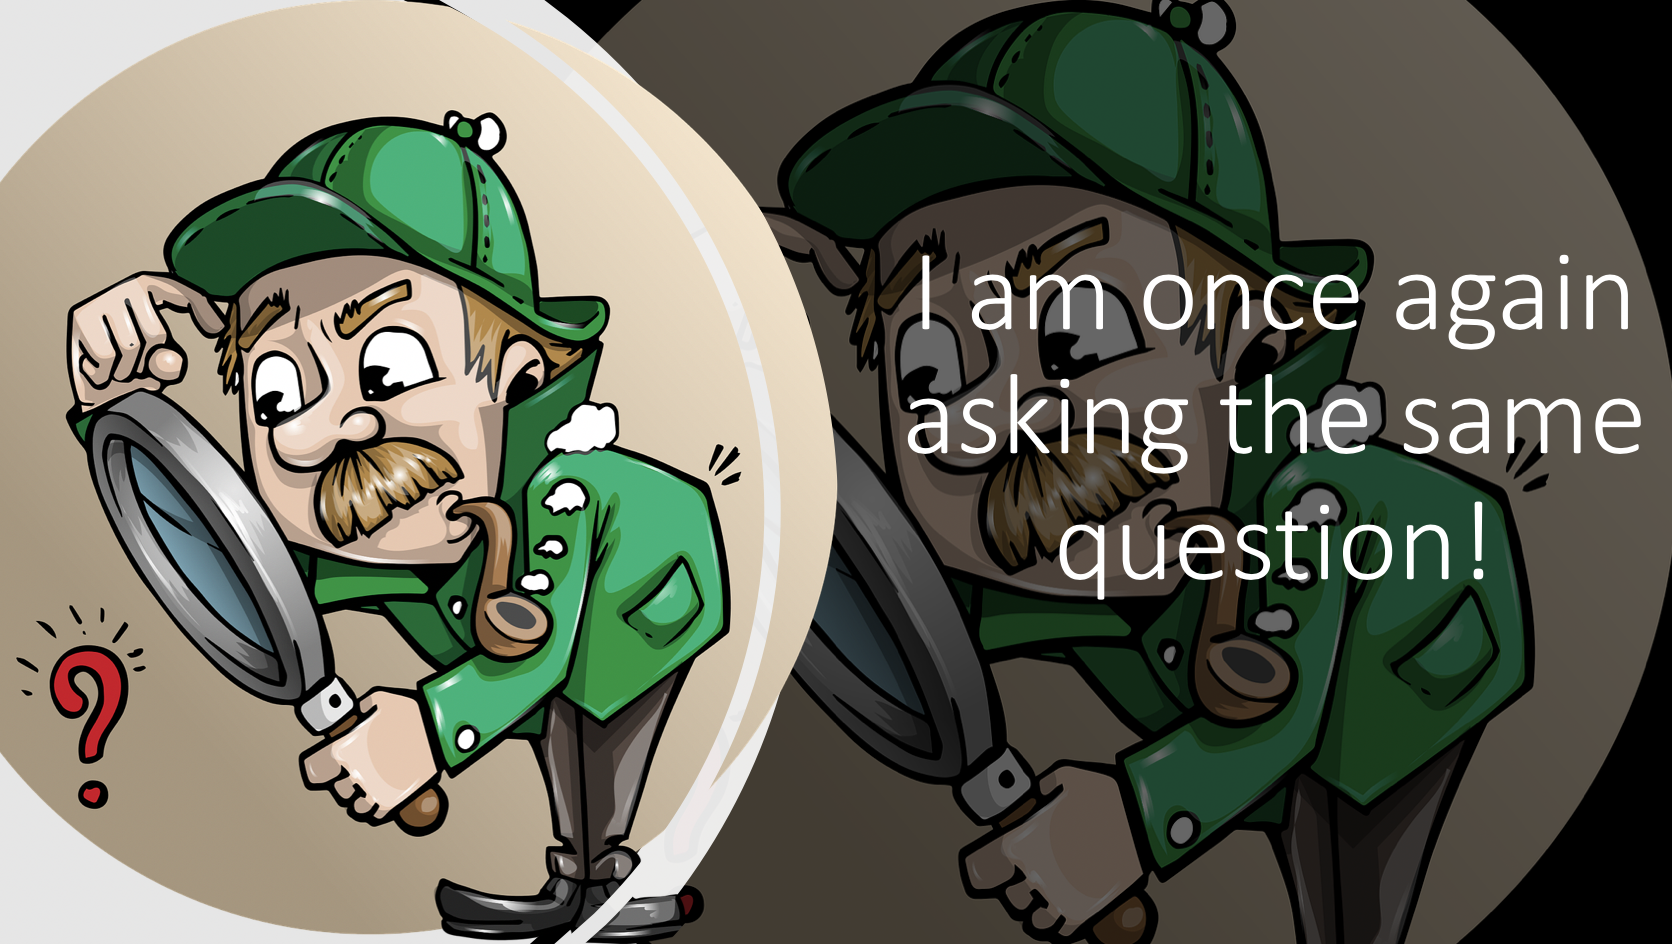

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import numpy as np
from tqdm import tqdm
from tensorflow.keras.models import Model

In [119]:
df = pd.read_csv("./questions.csv")
df.dropna(inplace=True)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [120]:
df.shape

(404348, 6)

In [121]:
#first we shuffle our dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [124]:
df_test = df.sample(10240)
df_train = df.drop(df_testa.index)
print("Train set:", len(df_train), "Test set:", len(df_test))
del(df) # remove to free memory

Train set: 394108 Test set: 10240


In [125]:
data_train = df_train[df_train['is_duplicate'] == 1]
len(data_train)

145608

In [126]:
tokenzer = Tokenizer(oov_token="oov")
tokenzer.fit_on_texts(data_train["question1"])
tokenzer.fit_on_texts(data_train["question2"])
Q1_tokened = tokenzer.texts_to_sequences(data_train["question1"])
Q2_tokened = tokenzer.texts_to_sequences(data_train["question2"])

In [127]:
data_train["question1"][0]

'Sometimes Arnab Goswami is very rude and biased in his TV show "The News Hour". Is it only for the TRP ratings or are debates done in this way?'

In [128]:
Q1_tokened[0]

[1814,
 1134,
 1126,
 4,
 381,
 3581,
 14,
 1660,
 9,
 226,
 357,
 773,
 2,
 1032,
 2271,
 4,
 21,
 298,
 18,
 2,
 25326,
 6505,
 35,
 11,
 3270,
 322,
 9,
 108,
 41]

In [132]:
Q1_train = pad_sequences(Q1_tokened, maxlen=450, padding='post', truncating='post')
Q2_train = pad_sequences(Q2_tokened, maxlen=450, padding='post', truncating='post')

In [217]:
Data = tf.data.Dataset.from_tensor_slices((Q1_train,Q2_train))
valid_size = int(0.2*len(Data))
valid = Data.take(valid_size).batch(64,drop_remainder=True)
train = Data.skip(valid_size).shuffle(1000).batch(64,drop_remainder=True)

In [134]:
#prepare test data
test_label = np.array(df_test["is_duplicate"])
test_Q1 = tokenzer.texts_to_sequences(df_test["question1"])
test_Q2 = tokenzer.texts_to_sequences(df_test["question2"])
Q1_test = pad_sequences(test_Q1, maxlen=300, padding='post', truncating='post')
Q2_test = pad_sequences(test_Q2, maxlen=300, padding='post', truncating='post')

test_data = tf.data.Dataset.from_tensor_slices((Q1_test,Q2_test,test_label)).batch(128,drop_remainder=True)

# Define model

## first we transfer learning from glove embedding 

In [13]:
dict_w2v = {}
with open('D:\TensorFlow\Trying\glove.6B/glove.6B.50d.txt', "r",encoding="utf8") as file:
    for line in file:
        tokens = line.split()
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)
        if vector.shape[0] == 50:
            dict_w2v[word] = vector
        else:
            print("There was an issue with " + word)
        # let's check the vocabulary size
print("Dictionary Size: ", len(dict_w2v))

Dictionary Size:  400000


In [135]:
embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [136]:
word2idx = tokenzer.word_index
idx2word = {value:key for key,value in word2idx.items()}

In [137]:
unk_cnt = 0
unk_set = set()
for word in word2idx.keys():
    embedding_vector = dict_w2v.get(word)
    if embedding_vector is not None:
        tkn_id = word2idx[word]
        embedding_matrix[tkn_id-1] = embedding_vector
    else:
        unk_cnt += 1
        unk_set.add(word)
# Print how many weren't found
print("Total unknown words: ", unk_cnt)

Total unknown words:  5022


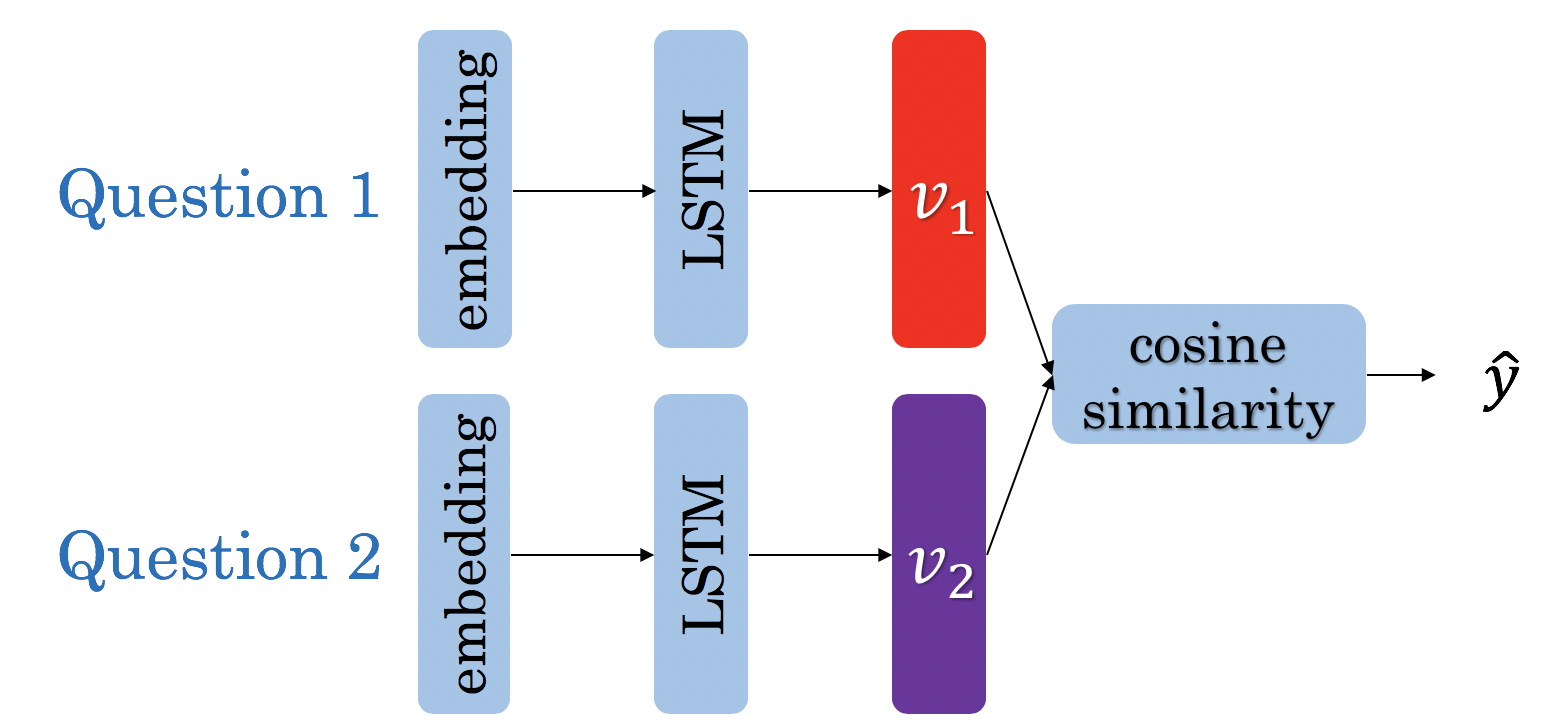

In [138]:
def initialize_base_network(vocab_size = vocab_size, d_model = 128, d_dense = 64):
    model = tf.keras.Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, mask_zero=True,weights=[embedding_matrix], trainable=True))
    model.add(layers.LSTM(d_model))
    model.add(layers.Dense(d_dense))
    model.add(layers.Lambda(lambda x : x / tf.math.sqrt(tf.math.reduce_sum(x * x, axis=-1, keepdims=True))))
    return model

In [139]:
model = initialize_base_network(vocab_size=vocab_size)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          1558350   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
lambda_1 (Lambda)            (None, 64)                0         
Total params: 1,658,254
Trainable params: 1,658,254
Non-trainable params: 0
_________________________________________________________________


# Define Loss

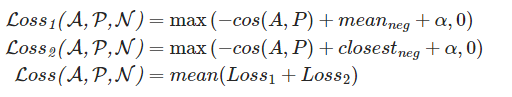

In [140]:
#loss Function
from tensorflow.keras.losses import Loss
class TripletLoss(Loss):
    def __init__(self,margin=0.1):
        
        super().__init__()
        
        self.margin = margin
        
    def call(self,v1,v2):

        scores = tf.matmul(v1, tf.transpose(v2))  

        batch_size = len(scores)

        positive = tf.linalg.diag_part(scores)  

        #closest negative
        negative_without_positive = scores - 2.0 * tf.eye(batch_size)

        closest_negative = tf.math.reduce_max(negative_without_positive,axis=1)

        #mean negative
        negative_zero_on_duplicate = scores * (1.0 - tf.eye(batch_size))

        mean_negative = tf.math.reduce_sum(negative_zero_on_duplicate, axis=1) / (batch_size-1)

        #calculate total loss
        triplet_loss1 = tf.math.maximum(closest_negative - positive + self.margin ,0)

        triplet_loss2 = tf.math.maximum(mean_negative - positive + self.margin ,0)

        triplet_loss = tf.math.reduce_mean(triplet_loss1 + triplet_loss2)

        return triplet_loss

# Train

In [141]:
def train_data_for_one_epoch(model, data_train, optimizer, loss_object):
    
    pbar = tqdm(total=len(list(enumerate(data_train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    train_losses = []
    
    for step,(q1,q2) in enumerate(data_train):
        with tf.GradientTape() as tape: 
            
            v1 = model(q1)
            v2 = model(q2)
            loss_value = loss_object(v1, v2)
      
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
        train_losses.append(loss_value)
        pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
        pbar.update()
    return train_losses

In [142]:
def valid_data_for_one_epoch(model, data_valid, loss_object):
    valid_losses = []
    for q1, q2 in data_valid:
        v1 = model(q1)
        v2 = model(q2)
        loss_value = loss_object(v1, v2)
        valid_losses.append(loss_value)
    return valid_losses

In [218]:
def training_function(model, data_train, data_valid, epochs=10):
    optimizer = tf.keras.optimizers.Adam()
    loss_object = TripletLoss(0.1)
    
    epochs_val_losses, epochs_train_losses = [], []
    print(f"Training Started: \nWe train for {epochs} epochs\n")
    for epoch in range(epochs):
        #training
        train_losses = train_data_for_one_epoch(model, data_train, optimizer, loss_object)
        epochs_train_losses.append(np.mean(train_losses))
            
        #Validation
        valid_losses = valid_data_for_one_epoch(model, data_valid, loss_object) 
        epochs_val_losses.append(np.mean(valid_losses))
            
        print('Epoch %s: Train loss: %.4f  Validation Loss: %.4f\n' % (epoch, float(epochs_train_losses[epoch]),
                                                                       float(epochs_val_losses[epoch])))

In [219]:
#we train for 5 epochs
training_function(model, train, valid, epochs=5)

Training Started: 
We train for 5 epochs



Training loss for step 1819: 0.1183: 100%|██████████| 1820/1820 


Epoch 0: Train loss: 0.1110  Validation Loss: 0.1151



Training loss for step 1819: 0.0885: 100%|██████████| 1820/1820 


Epoch 1: Train loss: 0.1099  Validation Loss: 0.1149



Training loss for step 1819: 0.1346: 100%|██████████| 1820/1820 


Epoch 2: Train loss: 0.1093  Validation Loss: 0.1146



Training loss for step 1819: 0.1070: 100%|██████████| 1820/1820 


Epoch 3: Train loss: 0.1088  Validation Loss: 0.1144



Training loss for step 1819: 0.0828: 100%|██████████| 1820/1820 


Epoch 4: Train loss: 0.1083  Validation Loss: 0.1141



In [216]:
# we will save our model after training 
model.save_weights('Question_dublicates_weights.h5')

## Evaluation

In [36]:
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()

In [188]:
def test(model, test_data, threshold = 0.7):
    accuracy= 0 
    len_data = 10240
    for q1, q2 ,label in test_data:
        v1 = model(q1)
        v2 = model(q2)
        scores = tf.matmul(v1, tf.transpose(v2))
        positive = tf.linalg.diag_part(scores)
        d = positive >= threshold
        accuracy += sum(d == label)
  
    accuracy = accuracy / len_data
    return accuracy

In [220]:
accuracy = test(model, test_data)
print(f"accuracy is : {accuracy}")

accuracy is : 0.42548828125


In [221]:
def classify(model, question_1, question_2, tokenizer, threshold=0.7):
    q1_tokenized = tokenizer.texts_to_sequences(question_1)
    q2_tokenized = tokenizer.texts_to_sequences(question_2)
    
    q1 = pad_sequences(q1_tokenized, maxlen=300, padding='post', truncating='post')
    q2 = pad_sequences(q2_tokenized, maxlen=300, padding='post', truncating='post')
    
    v1 = model(q1)
    v2 = model(q2)
    
    d = np.dot(v1, v2.T)
    res = d > threshold  
    
    if res:
        return "Similar" 
    else:
        return "different"

In [222]:
question_1 = ["what is your age?"]
question_2 = ["how old are you?"]

In [223]:
classify(model, question_1, question_2, tokenizer=tokenzer)

'Similar'

In [224]:
question_1 = ["what is your name?"]
question_2 = ["can you tell me your name?"]

In [225]:
classify(model, question_1, question_2, tokenizer=tokenzer)

'Similar'